<a href="https://colab.research.google.com/github/sasualx/AlexanGPT2/blob/master/Lyrics_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 394.7MB 43kB/s 
2.4.0


## Necessary Libraries

In [ ]:
import tensorflow as tf
from google.colab import drive
import tensorflow.keras.utils as ku
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
#left out Adam, regularizers

## Loading Lyrics

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/" + "DL-NLP/Data/"
lyrics = open(path + "bruno-mars.txt").read() 

Mounted at /content/drive


# Stopwords
The lyrics files contain certain 

*   The lyrics files contain certain stopwords which aren't common to all e.g. Chorus.
*   These have to be checked manually for each file and dealt with.

In [ ]:
stopWords = ["(",")","[","]","/","\\",".",",",":",'"']
removeWords = ["[Chorus:]", "CHORUS", "[Chorus]", "Chorus:"]

## Building a corpus from lyrics

In [ ]:
corpus = lyrics.lower().split("\n")
corpus[0:10]

['now greetings to the world! standing at this liquor store,',
 'whiskey coming through my pores,',
 'feeling like i run this whole block.',
 'lotto tickets cheap beer',
 "that's why you can catch me here,",
 "tryna scratch my way up to the top. 'cause my job got me going nowhere,",
 "so i ain't got a thing to lose.",
 "take me to a place where i don't care,",
 "this is me and my liquor store blues. i'll take one shot for my pain,",
 'one drag for my sorrow.']

## Replacing Stopwords and removing certain words

In [ ]:
for i in range(len(stopWords)):
  corpus = [line.replace(stopWords[i], "") for line in corpus]

for j in range(len(removeWords)):
  corpus = [line.replace(removeWords[j], "") for line in corpus]

# Removing any leading or trailing characters and any empty elements.

In [ ]:
corpus = [word.strip() for word in corpus if word.strip()!=""]
print("Length of corpus: ", len(corpus))

Length of corpus:  3270


# Using the Tokenizer
 

*   We get the integer representation for each word.
*   This includes Out of Vocabulary words such as names.
*   Word index with key = word, value = integer generated.
*   Reversed to use the integer as the key and identify.




In [ ]:
tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
reversedWI = {v: k for k, v in tokenizer.word_index.items()}
print("Total words: ", total_words)

Total words:  1900


# n-grams and Padding
* Use the word index to get text to sequences.
* Pad the sequences of different length


In [ ]:
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_seq = token_list[:i+1]
    input_sequences.append(n_gram_seq)

print("Total seq: ", len(input_sequences)) 

Total seq:  23625


In [ ]:
print(reversedWI[47], reversedWI[526], reversedWI[7], reversedWI[4], reversedWI[134], reversedWI[361]) 

now greetings to the world standing


In [ ]:
max_len =  max([len(i) for i in input_sequences])
print(max_len)

181


In [ ]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen= max_len, padding= "pre"))
print(input_sequences)

[[  0   0   0 ...   0  47 526]
 [  0   0   0 ...  47 526   7]
 [  0   0   0 ... 526   7   4]
 ...
 [  0   0   0 ...   8   8   8]
 [  0   0   0 ...   8   8   8]
 [  0   0   0 ...   8   8   8]]


In [ ]:
reversedWI[1]

'OOV'

# Splitting into predictors and labels
*    Last column is the label.
*    Pre padding done for labelling last.
*    One-hot encoding with classes equal to total number of words.

In [ ]:
train_data, labels = input_sequences[:, :-1], input_sequences[:,-1]
labels = ku.to_categorical(labels, num_classes = total_words)
print(labels)
#np.argmax(labels[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# The Model


In [ ]:
embeddingSize = 500
nodes = 150

In [ ]:
model = Sequential()
model.add(Embedding(total_words, embeddingSize, input_length = max_len - 1))
model.add(Bidirectional(LSTM(nodes, return_sequences = True)))
model.add(Bidirectional(LSTM(nodes, return_sequences = True)))
model.add(Dropout(0.1))
model.add(LSTM(nodes))
model.add(Dense(total_words, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)))
model.add(Dense(total_words, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 180, 500)          950000    
_________________________________________________________________
bidirectional (Bidirectional (None, 180, 300)          781200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 180, 300)          541200    
_________________________________________________________________
dropout (Dropout)            (None, 180, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense (Dense)                (None, 1900)              286900    
_________________________________________________________________
dense_1 (Dense)              (None, 1900)              3

In [ ]:
epochs= 100
history = model.fit(train_data, labels, epochs = epochs, verbose=1)

Epoch 1/100
739/739 [==============================] - 61s 65ms/step - loss: 6.5726 - accuracy: 0.0333
Epoch 2/100
739/739 [==============================] - 49s 66ms/step - loss: 5.6687 - accuracy: 0.0425
Epoch 3/100
739/739 [==============================] - 49s 66ms/step - loss: 5.3964 - accuracy: 0.0648
Epoch 4/100
739/739 [==============================] - 49s 66ms/step - loss: 5.1525 - accuracy: 0.0793
Epoch 5/100
739/739 [==============================] - 49s 66ms/step - loss: 4.9801 - accuracy: 0.0928
Epoch 6/100
739/739 [==============================] - 49s 66ms/step - loss: 4.7869 - accuracy: 0.1149
Epoch 7/100
739/739 [==============================] - 49s 66ms/step - loss: 4.5720 - accuracy: 0.1526
Epoch 8/100
739/739 [==============================] - 48s 66ms/step - loss: 4.3358 - accuracy: 0.1858
Epoch 9/100
739/739 [==============================] - 49s 67ms/step - loss: 4.1037 - accuracy: 0.2190
Epoch 10/100
739/739 [==============================] - 49s 66ms/step - l

In [ ]:
path = "/content/drive/My Drive/DL-NLP/" 
model.save(path + "Bruno_Mars_LSTM.h5")
#model = keras.models.load_model(path + "Bruno_Mars_LSTM.h5")

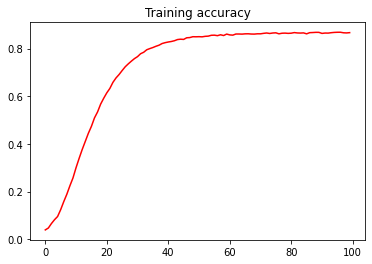

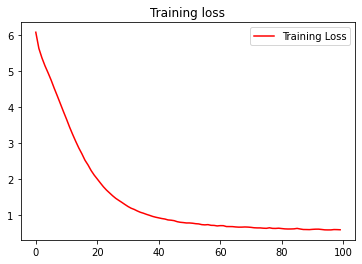

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

# Generating new lyrics
*   As we don't know where one song ends and another starts, it's hard to find the average number of lines in a song.
*   We observe few songs and try to find the average number of words in all songs.
*   After getting the sequence and padding the seed text, we get the predicted word.
*   Then we find the word which is predicted using the word index.

In [ ]:
min_lines = 32

allSongs = corpus
wordsByLines = []
for loop1 in range(len(allSongs)):
  for loop2 in range(min_lines):
    if (loop1 == 0):
      wordsByLines.append(len([elem.strip() for elem in allSongs[loop2].split(" ") if elem.strip()!=""]))
    else:
      wordsByLines[loop2] = (wordsByLines[loop2]+len([elem.strip() for elem in allSongs[loop2].split(" ") if elem.strip()!=""]))/2
wordsInTotal = int(sum(wordsByLines))
print("Average number of words per song :",wordsInTotal)

Average number of words per song : 246


In [ ]:
print(wordsByLines)

[10.0, 5.0, 7.0, 4.0, 7.0, 15.0, 8.0, 9.0, 15.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 9.0, 5.0, 8.0, 8.0, 17.0, 8.0, 9.0, 15.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 13.0, 8.0, 12.0]


In [ ]:
seed_text = "You are"
num_words = 200

for _ in range(num_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_len-1, padding='pre')
  predicted = model.predict_classes(token_list, verbose = 0)
  output = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output = word
      break
  seed_text += " " + output

print(seed_text)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


You are my treasure yeah you you you you are treasure that is what you are ooh ooh ooh you are i lose i know wrong i come here with me all ya'self into my pocket full of cream comes own night seems if i see you into the same start along they said it feels when we grind gonna wait to look good wait all you ain't was someday this little chapel on the sea boy that we out home silky smooth and they picture all me going crazy ooo my baby she got me oh no she locked me in prison like a criminal damn alone in my penthouse bag every morning i must perfect wait in you gone the first wish we do or all this little breath seems might pretend we are here we are in this big old empty room room big old empty room big old empty room drinks on your attitude dame puedo minutos steer me wrong damn hands on it all named natalie she ran away with all my money ooh don't get up or does this little chapel on the crowd activate it was soon soon spiritual named i would go through all


In [ ]:
newLyrics = [elem for elem in seed_text.split(" ")]
print(newLyrics)

['You', 'are', 'my', 'treasure', 'yeah', 'you', 'you', 'you', 'you', 'are', 'treasure', 'that', 'is', 'what', 'you', 'are', 'ooh', 'ooh', 'ooh', 'you', 'are', 'i', 'lose', 'i', 'know', 'wrong', 'i', 'come', 'here', 'with', 'me', 'all', "ya'self", 'into', 'my', 'pocket', 'full', 'of', 'cream', 'comes', 'own', 'night', 'seems', 'if', 'i', 'see', 'you', 'into', 'the', 'same', 'start', 'along', 'they', 'said', 'it', 'feels', 'when', 'we', 'grind', 'gonna', 'wait', 'to', 'look', 'good', 'wait', 'all', 'you', "ain't", 'was', 'someday', 'this', 'little', 'chapel', 'on', 'the', 'sea', 'boy', 'that', 'we', 'out', 'home', 'silky', 'smooth', 'and', 'they', 'picture', 'all', 'me', 'going', 'crazy', 'ooo', 'my', 'baby', 'she', 'got', 'me', 'oh', 'no', 'she', 'locked', 'me', 'in', 'prison', 'like', 'a', 'criminal', 'damn', 'alone', 'in', 'my', 'penthouse', 'bag', 'every', 'morning', 'i', 'must', 'perfect', 'wait', 'in', 'you', 'gone', 'the', 'first', 'wish', 'we', 'do', 'or', 'all', 'this', 'little'

In [ ]:
wordsByLines = [int(elem) for elem in wordsByLines]
stringLyrics = ""
startPos = 0
endPos = 0
for loop in range(len(wordsByLines)):
  endPos = endPos + wordsByLines[loop]
  tempLine = ' '.join(elem for elem in newLyrics[startPos:endPos])
  stringLyrics = stringLyrics + '\n' + tempLine
  startPos = endPos

print(stringLyrics)


You are my treasure yeah you you you you are
treasure that is what you
are ooh ooh ooh you are i
lose i know wrong
i come here with me all ya'self
into my pocket full of cream comes own night seems if i see you into
the same start along they said it feels
when we grind gonna wait to look good wait
all you ain't was someday this little chapel on the sea boy that we out
home silky smooth and they
picture all me going
crazy ooo my baby
she got me oh no
she locked me in prison
like a criminal damn
alone in my penthouse bag every morning i must
perfect wait in you gone
the first wish we do or all this
little breath seems might pretend we are here
we are in this big old empty room room big old empty room big old empty room
drinks on your attitude dame puedo minutos steer
me wrong damn hands on it all named natalie
she ran away with all my money ooh don't get up or does this little
chapel on the crowd activate
it was soon soon
spiritual named i would
go through all







In [ ]:
saveLyrics = open("/content/drive/My Drive/DL-NLP/Generated/Bruno_Mars_LSTM.txt", "wt")
saveLyrics.write(stringLyrics)
saveLyrics.close()